## Time Series Forecasting - LSTM

**Raynold Panji Zulfiandi**
> Datasets: https://www.kaggle.com/datasets/utathya/electricity-consumption

## Download Dataset

In [1]:
# install kaggle package
!pip install -q kaggle

In [2]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raynoldpanji","key":"2b7006946bc90d89f78541c3397cb478"}'}

In [3]:
# make directory and change permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
# download dataset, choose 'copy api command' from kaggle dataset
!kaggle datasets download -d utathya/electricity-consumption

  0% 0.00/458k [00:00<?, ?B/s]
100% 458k/458k [00:00<00:00, 113MB/s]


In [5]:
!mkdir dataset
!unzip electricity-consumption.zip -d dataset
!ls dataset

Archive:  electricity-consumption.zip
  inflating: dataset/test.csv        
  inflating: dataset/train.csv       
test.csv  train.csv


## Data Preprocessing

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM

In [8]:
data_train = pd.read_csv('dataset/train.csv')
data_train.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [9]:
data_train.isnull().sum()

ID                         0
datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

In [10]:
data_train['datetime']

0        2013-07-01 00:00:00
1        2013-07-01 01:00:00
2        2013-07-01 02:00:00
3        2013-07-01 03:00:00
4        2013-07-01 04:00:00
                ...         
26491    2017-06-23 19:00:00
26492    2017-06-23 20:00:00
26493    2017-06-23 21:00:00
26494    2017-06-23 22:00:00
26495    2017-06-23 23:00:00
Name: datetime, Length: 26496, dtype: object

In [11]:
data_train['datetime'] = pd.to_datetime(data_train['datetime'])
# data_test['datetime'] = pd.to_datetime(data_test['datetime'])

In [12]:
time = np.array(data_train['datetime'].values)
series = np.array(data_train['temperature'].values)
 
time_split_len = int(len(series) * 0.8)
series_train = series[:time_split_len]
series_test = series[time_split_len:]
time_train = time[:time_split_len]
time_test = time[time_split_len:]

print(f'Total Data Train : {series_train.shape[0]}')
print(f'Total Data Validation : {series_test.shape[0]}')

Total Data Train : 21196
Total Data Validation : 5300


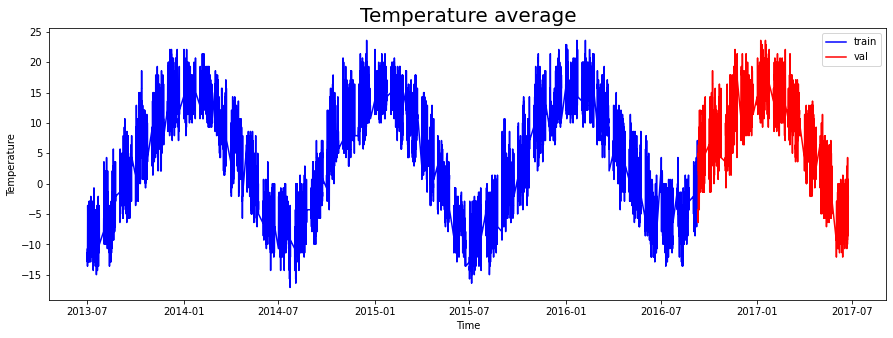

In [13]:
plt.figure(figsize=(15,5))
plt.plot(time_train, series_train, color='blue', label='train')
plt.plot(time_test, series_test, color='red', label='val')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()

plt.title('Temperature average', fontsize=20);

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

## Training model

In [42]:
train_set = windowed_dataset(series_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(series_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [43]:
# Mencari nilai MAE dari model < 10% skala data
MAE = (data_train['temperature'].max() - data_train['temperature'].min()) * 0.1
print(MAE)

4.07


In [44]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [45]:
ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto'
)

In [46]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=test_set, epochs=50, callbacks=[ES])

if(history.history['mae'][-1] < MAE and history.history['val_mae'][-1] < MAE):
  print("\n\nMAE dibawah 10%")

Epoch 1/50
212/212 [==============================] - 14s 38ms/step - loss: 7.2487 - mae: 7.7382 - val_loss: 6.5597 - val_mae: 7.0499
Epoch 2/50
212/212 [==============================] - 6s 29ms/step - loss: 4.8337 - mae: 5.3165 - val_loss: 3.3489 - val_mae: 3.8197
Epoch 3/50
212/212 [==============================] - 6s 29ms/step - loss: 3.8484 - mae: 4.3271 - val_loss: 2.9225 - val_mae: 3.3924
Epoch 4/50
212/212 [==============================] - 6s 29ms/step - loss: 3.5093 - mae: 3.9851 - val_loss: 2.7439 - val_mae: 3.2098
Epoch 5/50
212/212 [==============================] - 7s 34ms/step - loss: 3.2187 - mae: 3.6912 - val_loss: 2.4296 - val_mae: 2.8948
Epoch 6/50
212/212 [==============================] - 10s 47ms/step - loss: 2.9452 - mae: 3.4150 - val_loss: 2.2062 - val_mae: 2.6691
Epoch 7/50
212/212 [==============================] - 8s 34ms/step - loss: 2.5925 - mae: 3.0591 - val_loss: 1.9786 - val_mae: 2.4369
Epoch 8/50
212/212 [==============================] - 8s 38ms/step 

## Plot MAE dan Loss

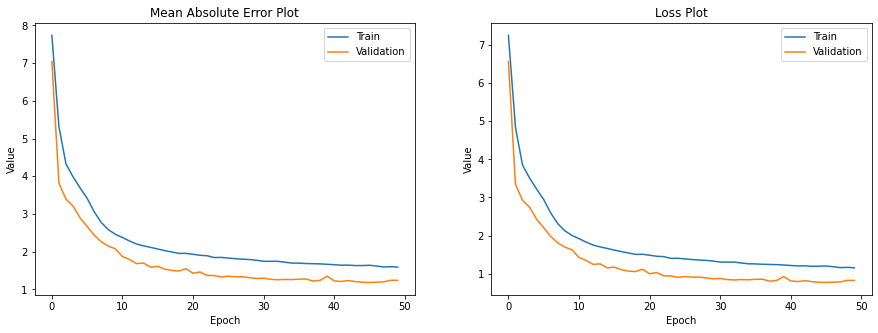

In [49]:
figure = plt.figure(figsize = (15, 5))

figure.add_subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'], loc = 'upper right')

figure.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'], loc = 'upper right')

plt.show()

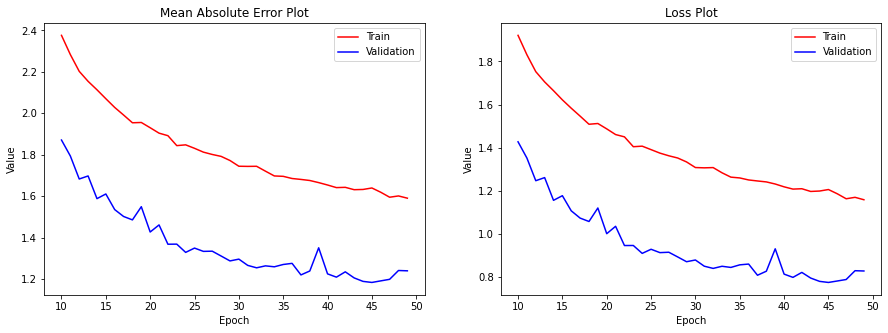

In [50]:
## Plot Zoomed MAE and Loss
epochs_zoom = range(len(history.history['loss']))[10:]

mae_zoom = history.history['mae'][10:]
val_mae_zoom = history.history['val_mae'][10:]

loss_zoom = history.history['loss'][10:]
val_loss_zoom = history.history['val_loss'][10:]



figure = plt.figure(figsize = (15, 5))

figure.add_subplot(1, 2, 1)
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, val_mae_zoom, 'b')
plt.title('Mean Absolute Error Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'], loc = 'upper right')

figure.add_subplot(1, 2, 2)
plt.plot(epochs_zoom, loss_zoom, 'r')
plt.plot(epochs_zoom, val_loss_zoom, 'b')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'], loc = 'upper right')

plt.show()